In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os
from tqdm import tqdm

import torch
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from utils import load_model, save_model, show_images

device = torch.device('cpu')
train = True

# Data

We will be using the MNIST dataset for this demonstration

In [2]:
data_dir = './data'
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])
trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Diffusion and denoising models

The point of this short demonstration is to implement the diffusion model originally proposed in the [this paper](https://arxiv.org/pdf/2006.11239.pdf). We shall train it in tandem with a denoising model, after which we shall generate some normal samples and some inpainting samples. 

As the denoising model we shall use a model based on the UNet architecture.

We have implemented in the diffusion model the capacity condition on both labels and time, and we shall compare how the models compare to each other with different conditionings. 

In [3]:
from diffusion import DiffusionModel
from denoising import UNet

diffusion_no_cond = DiffusionModel(UNet())
diffusion_no_class = DiffusionModel(UNet(time_emb_dim=32))
diffusion_no_time = DiffusionModel(UNet(num_classes=11))
diffusion = DiffusionModel(UNet(num_classes=11, time_emb_dim=32))

diffusion_no_cond.to(device)
diffusion_no_class.to(device)
diffusion_no_time.to(device)
diffusion.to(device)

models = [diffusion_no_cond, 
          diffusion_no_class,
          diffusion_no_time,
          diffusion]

print('model init done')

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


model init done


# Training 

Now we shall train the models. For this demo we used 25 epochs and a lr=0.001 with an Adam optimizer for all the different diffusion models. 

In [ ]:
def train_ddpm(diffusion, epochs, optimizer, trainloader, train=True, dummy_label_ratio=0.1, filename=None):
    if not train:
        assert filename is not None, "Filename is needed to load a model weights"
        load_model(diffusion, filename, device)
        return
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()

            batch_size = images.size(0)

            images, labels = images.to(device), labels.to(device)
            # set 10% of the labels as the dummy label
            label_mask = torch.rand(batch_size) < dummy_label_ratio
            labels[label_mask] = 10
            time = torch.randint(diffusion.timesteps, size=(batch_size,)).to(device)
            loss = diffusion.loss(images, time, labels)
            running_loss += loss.item() / len(trainloader)

            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed with a average loss of {running_loss}")
    if filename is not None:
        save_model(diffusion, filename)


# default filenames for models
filenames = ['diffusion_model_no_cond.pth',
             'diffusion_model_no_class.pth',
             'diffusion_model_no_time.pth',
             'diffusion_model.pth']
# train, or load, all the models
for i, model in enumerate(models):
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    file = filenames[i]
    train_ddpm(model, 25, optim, trainloader, train=train, filename=file)


Model loaded from diffusion_model_no_cond.pth.
Model loaded from diffusion_model_no_class.pth.
Model loaded from diffusion_model_no_time.pth.
Model loaded from diffusion_model.pth.


# Sampling

Now we can sample our different models below. It is clear to see that without the time embeddings the model produces very noisy and sometimes unrecognizable digits. Though if conditioned on only the classes if the image produced is not highly noisy it will correspond to the label. With both time and class the model produces recognizable digits and even the dummy label produces a random but legible digit.

No conditioning


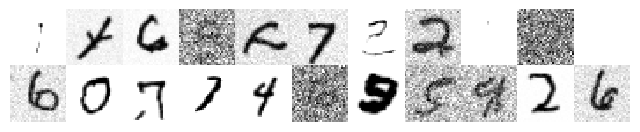

Conditioning on time only


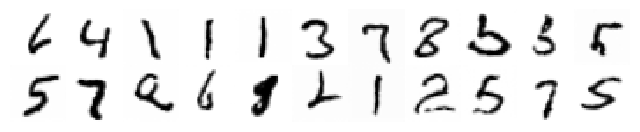

Conditioning on class only


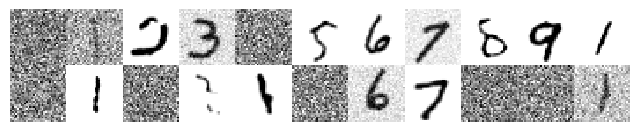

Conditioning on class and time


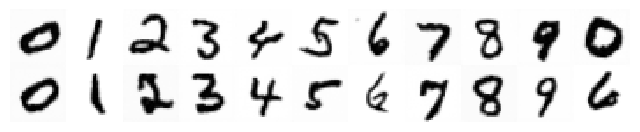

In [7]:
def sample_models(models, titles = None, device = 'cuda:0'):
    with torch.no_grad():
        rows = 2
        num_classes = 11
        x_shape = (rows * num_classes, 1, 32, 32)
        init_x = torch.randn(*x_shape, device=device)
        labels = torch.cat([torch.arange(num_classes) for _ in range(rows)], dim=0).to(device)
        samples = []
        for i, model in enumerate(models):
            samples = model.sample(x_shape, labels, init_x=init_x)
            samples01 = ((samples+1) / 2).clip(0,1)
            if titles is not None:
                print(titles[i])
            show_images(samples01, cmap='binary', ncol=num_classes)

titles = ['No conditioning',
          'Conditioning on time only',
          'Conditioning on class only',
          'Conditioning on class and time']
sample_models(models, titles)

# Inpainting

The diffusion model also has an implemented inpainting method, where we give our diffusion model only parts of images and the rest need to be generated. Below is an example of the masked images

Conditioning:


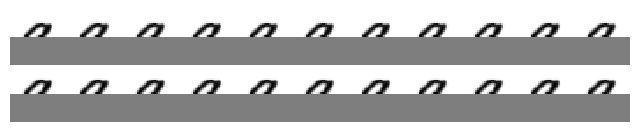

In [6]:

rows = 2
num_classes = 11
image, label = trainset[4]  # select one image from the dataset
images = image[None, 0].tile(rows*num_classes, 1, 1, 1)  # copy the image to generate multiple samples
images = images.to(device)
labels = torch.cat([torch.arange(num_classes) for _ in range(rows)], dim=0).to(device) # generate labels for the data
(batch_size, _, H, W) = images.shape

# mask out the bottom part of every image
mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
mask_known[:, :, :H//2, :] = 1
images_known = images * mask_known

samples01 = ((images_known + 1) / 2).clip(0, 1)
print('Conditioning:')
show_images(samples01[:rows*num_classes], cmap='binary', ncol=11)



Now we inpaint the masked images with each of the models. Here we see that even without conditioning on time the models do not give noisy results similar to just sampling the model, but the model with no conditioning on class or time generates more gibberish samples still. As expected, without class conditioning the digits tend to be 7, 8 or 9. Surprisingly the model conditioned on class only and the model conditioned on class and time seem to be producing similarly legible results.

No conditioning


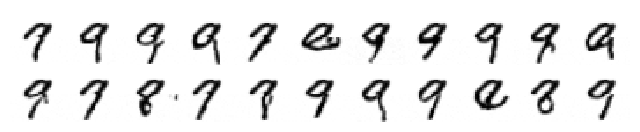

Conditioning on time only


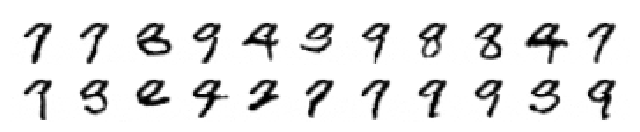

Conditioning on class only


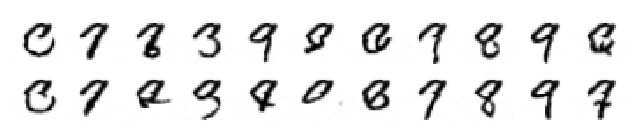

Conditioning on class and time


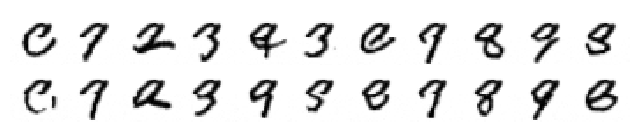

In [10]:
def inpaint_models(models, titles = None, device = 'cuda:0'):
    with torch.no_grad():
        device = torch.device(device)
        rows = 2
        num_classes = 11
        image, label = trainset[4]  # select one image from the dataset
        images = image[None, 0].tile(rows*num_classes, 1, 1, 1)  # copy the image to generate multiple samples
        images = images.to(device)
        labels = torch.cat([torch.arange(num_classes) for _ in range(rows)], dim=0).to(device) # generate labels for the data
        (batch_size, _, H, W) = images.shape

        # mask out the bottom part of every image
        mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
        mask_known[:, :, :H//2, :] = 1
        images_known = images * mask_known

        samples = []
        for i, model in enumerate(models):
            samples = model.inpaint(images_known, mask_known, labels)
            samples01 = ((samples + 1) / 2).clip(0, 1)
            if titles is not None:
                print(titles[i])
            show_images(samples01[:rows*num_classes], cmap='binary', ncol=11)

titles = ['No conditioning',
          'Conditioning on time only',
          'Conditioning on class only',
          'Conditioning on class and time']
inpaint_models(models, titles)